<a href="https://colab.research.google.com/github/Korniev/Machine-Learning-projects/blob/main/image_classification_dataset_90_animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers

mixed_precision.set_global_policy('mixed_float16')

print(tf.__version__)

2.17.0


Loading Dataset:

In [9]:
path = "/content/drive/MyDrive/Colab Notebooks/archive_90_animals.zip"

In [10]:
zip_path = path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

Verify the extracted files:

In [11]:
!ls /content/animals/animals/

antelope     cockroach	elephant     hippopotamus  lobster    parrot	      seahorse	turtle
badger	     cow	flamingo     hornbill	   mosquito   pelecaniformes  seal	whale
bat	     coyote	fly	     horse	   moth       penguin	      shark	wolf
bear	     crab	fox	     hummingbird   mouse      pig	      sheep	wombat
bee	     crow	goat	     hyena	   octopus    pigeon	      snake	woodpecker
beetle	     deer	goldfish     jellyfish	   okapi      porcupine       sparrow	zebra
bison	     dog	goose	     kangaroo	   orangutan  possum	      squid
boar	     dolphin	gorilla      koala	   otter      raccoon	      squirrel
butterfly    donkey	grasshopper  ladybugs	   owl	      rat	      starfish
cat	     dragonfly	hamster      leopard	   ox	      reindeer	      swan
caterpillar  duck	hare	     lion	   oyster     rhinoceros      tiger
chimpanzee   eagle	hedgehog     lizard	   panda      sandpiper       turkey


In [15]:
path = '/content/animals/animals/'

In [16]:
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

Split the Dataset into Train & Test

In [17]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                            imgpath    labels
0     /content/animals/animals/tiger/3f090f0f2a.jpg     tiger
1    /content/animals/animals/lizard/89fcf3e801.jpg    lizard
2  /content/animals/animals/kangaroo/590af7099b.jpg  kangaroo
3  /content/animals/animals/ladybugs/5b8db3578c.jpg  ladybugs
4       /content/animals/animals/dog/89af0e8454.jpg       dog
(3779, 3)
--------Validation----------
                                         imgpath labels
0   /content/animals/animals/duck/24f7e684eb.jpg   duck
1  /content/animals/animals/tiger/333dd0655b.jpg  tiger
2    /content/animals/animals/owl/002bb8e03b.jpg    owl
3    /content/animals/animals/bee/5f4eacc507.jpg    bee
4  /content/animals/animals/otter/7ee33914bc.jpg  otter
(1134, 3)
----------Test--------------
                                             imgpath       labels
0  /content/animals/animals/grasshopper/1fbdcee16...  grasshopper
1      /content/animals/animals/mouse/719c8d79b6.jpg 

Show sample from data

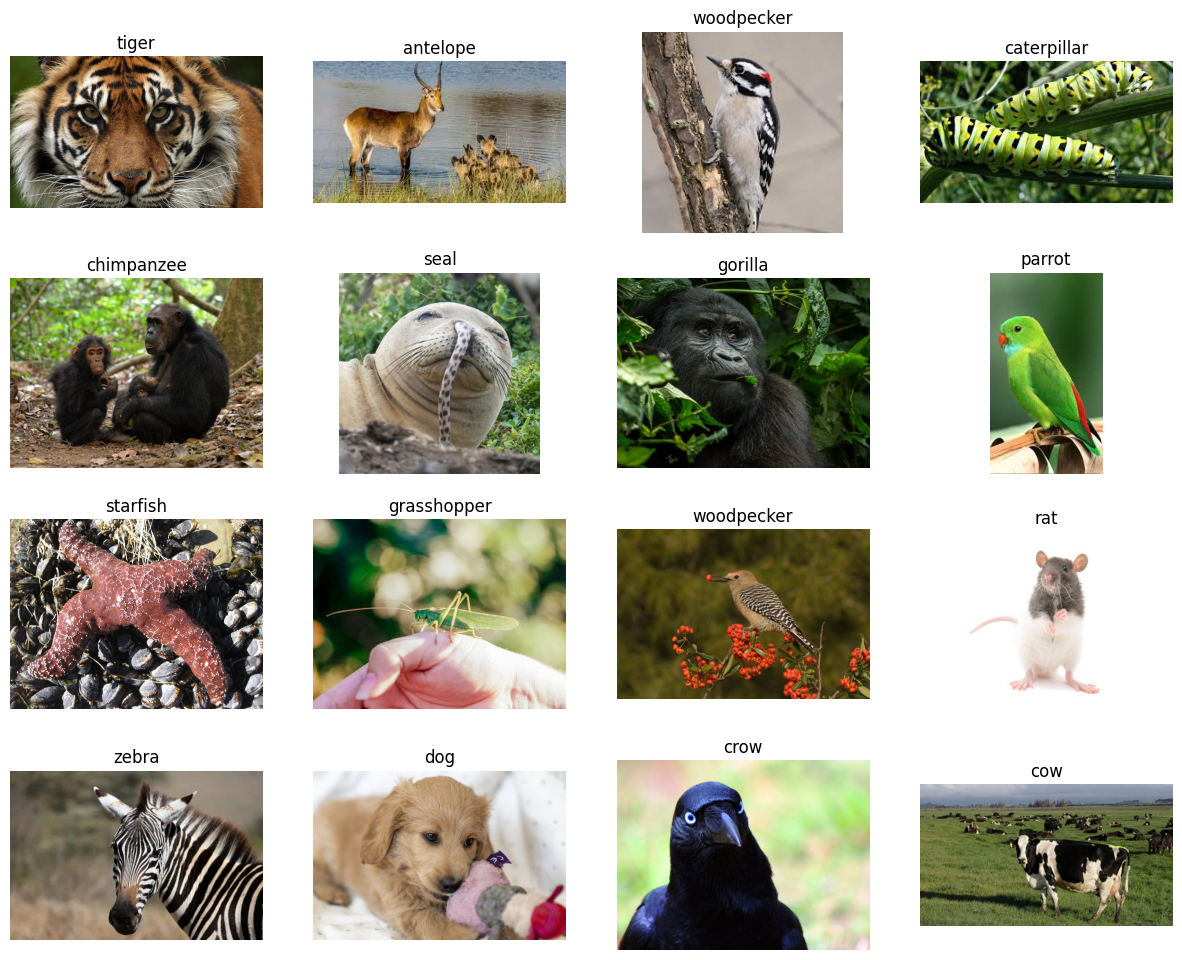

In [18]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

Creating Dataloaders:

In [19]:
%%time

BATCH_SIZE = 15
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.
CPU times: user 56.5 ms, sys: 13.2 ms, total: 69.7 ms
Wall time: 176 ms


Model Structure

In [20]:
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
num_classes = len(set(train_images.classes))

In [22]:
pretrained_model.summary()

Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,783,535 (41.14 MB)

In [28]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.15),
  layers.RandomZoom(0.15),
  layers.RandomContrast(0.15),
], name='AugmentationLayer')

In [29]:
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)

In [30]:
model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AugmentationLayer (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          23,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activationLayer (Activation)         │ (None, 90)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,201,161 (42.73 MB)

 Trainable params: 417,114 (1.59 MB)

 Non-trainable params: 10,784,047 (41.14 MB)

Training : Transfer Learning

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 20 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)